In [1]:
import numpy as np
import os
import pandas as pd

In [2]:
from IPython.display import display, clear_output

import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader

C:\Users\al_po\AppData\Local\Temp\ipykernel_12960\656011182.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
torch.cuda.is_available()

True

In [5]:
interactions_df = pd.read_csv('data_original/interactions_processed_kion.csv')
users_df = pd.read_csv('data_original/users_processed_kion.csv')
items_df = pd.read_csv('data_original/items_processed_kion.csv')

In [6]:
interactions_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72
1,699317,1659,2021-05-29,8317,100
2,656683,7107,2021-05-09,10,0
3,864613,7638,2021-07-05,14483,100
4,964868,9506,2021-04-30,6725,100


In [7]:
interactions_df = interactions_df[interactions_df['last_watch_dt'] < '2021-04-01']

In [8]:
interactions_df.shape

(263874, 5)

In [9]:
users_interactions_count_df = interactions_df.groupby(['user_id', 'item_id']).size().groupby('user_id').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['user_id']]
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users: 86614
# users with at least 5 interactions: 14563


In [10]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'user_id',
               right_on = 'user_id')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 263874
# of interactions from users with at least 5 interactions: 142670


In [11]:
import math

In [12]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['user_id', 'item_id'])['watched_pct'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(10)

# of unique user/item interactions: 142670


,user_id,item_id,watched_pct
0,21,849,6.375039
1,21,4345,6.658211
2,21,10283,6.658211
3,21,12261,6.658211
4,21,15997,6.658211
5,32,952,6.044394
6,32,4382,4.954196
7,32,4807,6.658211
8,32,10436,6.658211
9,32,12132,6.658211


In [13]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['user_id'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 114136
# interactions on Test set: 28534


In [14]:

#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('user_id')
interactions_train_indexed_df = interactions_train_df.set_index('user_id')
interactions_test_indexed_df = interactions_test_df.set_index('user_id')

In [15]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['item_id']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [16]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['item_id'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['item_id']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['item_id'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['item_id'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['item_id'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['item_id'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(tqdm(list(interactions_test_indexed_df.index.unique().values))):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['user_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

In [17]:

from IPython.display import display, clear_output

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [55]:

# Constants
SEED = 42 # random seed for reproducibility
LR = 1e-3 # learning rate, controls the speed of the training
WEIGHT_DECAY = 0.01 # lambda for L2 reg. ()
NUM_EPOCHS = 80 # num training epochs (how many times each instance will be processed)
GAMMA = 0.9995 # learning rate scheduler parameter
BATCH_SIZE = 3000 # training batch size
EVAL_BATCH_SIZE = 3000 # evaluation batch size.
DEVICE = 'cuda' #'cuda' # device to make the calculations on

In [19]:

total_df = interactions_train_df.append(interactions_test_indexed_df.reset_index())
total_df['user_id'], users_keys = total_df.user_id.factorize()
total_df['item_id'], items_keys = total_df.item_id.factorize()

train_encoded = total_df.iloc[:len(interactions_train_df)].values
test_encoded = total_df.iloc[len(interactions_train_df):].values

C:\Users\al_po\AppData\Local\Temp\ipykernel_12960\3875440146.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_df = interactions_train_df.append(interactions_test_indexed_df.reset_index())


In [20]:
from scipy.sparse import csr_matrix
shape = [int(total_df['user_id'].max()+1), int(total_df['item_id'].max()+1)]
X_train = csr_matrix((train_encoded[:, 2], (train_encoded[:, 0], train_encoded[:, 1])), shape=shape).toarray()
X_test = csr_matrix((test_encoded[:, 2], (test_encoded[:, 0], test_encoded[:, 1])), shape=shape).toarray()

In [21]:

# Initialize the DataObject, which must return an element (features vector x and target value y)
# for a given idx. This class must also have a length atribute
class UserOrientedDataset(Dataset):
    def __init__(self, X):
        super().__init__() # to initialize the parent class
        self.X = X.astype(np.float32)
        self.len = len(X)

    def __len__(self): # We use __func__ for implementing in-built python functions
        return self.len

    def __getitem__(self, index):
        return self.X[index]

In [22]:

# Initialize DataLoaders - objects, which sample instances from DataObject-s
train_dl = DataLoader(
    UserOrientedDataset(X_train),
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dl = DataLoader(
    UserOrientedDataset(X_test),
    batch_size = EVAL_BATCH_SIZE,
    shuffle = False
)

dls = {'train': train_dl, 'test': test_dl}

#### Добавим линейный слой, батчнорм, дропаут и заменим функцию активации, чтобы не попасть на мёртвые нейроны

In [23]:
class Model(nn.Module):
   def __init__(self, in_and_out_features = 8287):
       super().__init__()
       self.in_and_out_features = in_and_out_features
       self.hidden_size = 500

       self.sequential = nn.Sequential( # NN architecture, where the modules modify the data sequentially
           nn.Linear(in_and_out_features, self.hidden_size), # Linear transformation
           nn.BatchNorm1d(self.hidden_size), # Batch normalization
           nn.ELU(), # Activation function
           nn.Dropout(0.5), # Dropout
           nn.Linear(self.hidden_size, self.hidden_size), # Another Linear transformation
           nn.BatchNorm1d(self.hidden_size), # Batch normalization
           nn.ELU(), # Activation function
           nn.Dropout(0.5), # Dropout
           nn.Linear(self.hidden_size, in_and_out_features) # Final Linear transformation
       )

   def forward(self, x): # In the forward function, you define how your model runs, from input to output 
       x = self.sequential(x)
       return x


In [58]:

torch.manual_seed(SEED) # Fix random seed to have reproducible weights of model layers

model = Model()
model.to(DEVICE)

# Initialize GD method, which will update the weights of the model
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# Initialize learning rate scheduler, which will decrease LR according to some rule
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

def rmse_for_sparse(x_pred, x_true):
    mask = (x_true > 0)
    sq_diff = (x_pred * mask - x_true) ** 2
    mse = sq_diff.sum() / mask.sum()
    return mse ** (1/2)

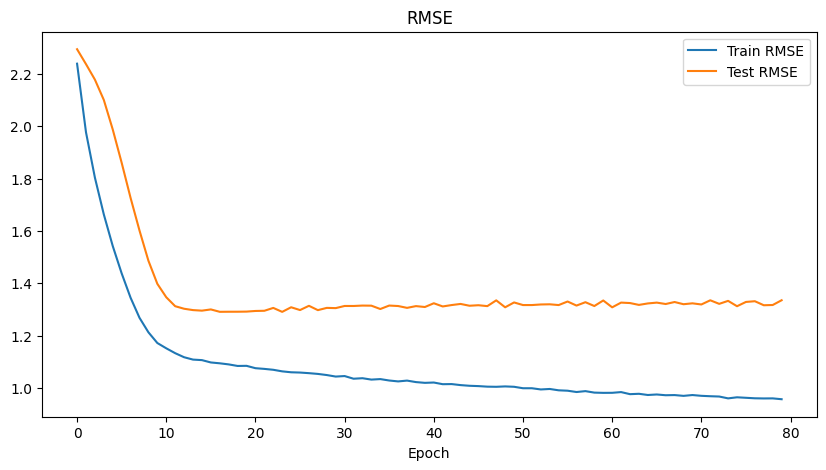

In [60]:
# Training loop
metrics_dict = {
    "Epoch": [],
    "Train RMSE": [],
    "Test RMSE": [],
}

# Train loop
for epoch in range(NUM_EPOCHS):
    metrics_dict["Epoch"].append(epoch)
    for stage in ['train', 'test']:
        with torch.set_grad_enabled(stage == 'train'): # Whether to start building a graph for a backward pass
            if stage == 'train':
                model.train() # Enable some "special" layers (will speak about later)
            else:
                model.eval() # Disable some "special" layers (will speak about later)

            loss_at_stage = 0 
            for batch in dls[stage]:
                batch = batch.to(DEVICE)
                x_pred = model(batch) # forward pass: model(x_batch) -> calls forward()
                loss = rmse_for_sparse(x_pred, batch) # ¡Important! y_pred is always the first arg
                if stage == "train":
                    loss.backward() # Calculate the gradients of all the parameters wrt loss
                    optimizer.step() # Update the parameters
                    scheduler.step()
                    optimizer.zero_grad() # Zero the saved gradient
                loss_at_stage += loss.item() * len(batch)
            rmse_at_stage = (loss_at_stage / len(dls[stage].dataset)) ** (1/2)
            metrics_dict[f"{stage.title()} RMSE"].append(rmse_at_stage)
            
    if (epoch == NUM_EPOCHS - 1) or epoch % 10 == 9:

        clear_output(True)
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        ax.set_xlabel('Epoch')
        ax.set_title('RMSE')
        ax.plot(metrics_dict['Train RMSE'], label='Train RMSE')
        ax.plot(metrics_dict['Test RMSE'], label='Test RMSE')
        plt.legend()
        plt.show()
        


In [61]:
with torch.no_grad():
    X_pred = model(torch.Tensor(X_test).to(DEVICE))
X_pred

tensor([[ 2.1629,  2.8264,  1.8380,  ...,  0.0217, -0.4193,  0.2698],
        [ 0.2148,  0.3935, -0.1397,  ..., -0.0202,  0.1199, -0.0294],
        [ 0.8186,  0.8202, -0.0635,  ..., -0.3951,  0.2273,  0.0771],
        ...,
        [ 0.2711,  0.5640, -0.2228,  ..., -0.2027,  0.1654,  0.1397],
        [ 0.7020,  1.3357,  0.6942,  ...,  0.0332,  0.2691,  0.3991],
        [ 0.5546,  0.8151,  0.1423,  ...,  0.0633,  0.0753, -0.1231]],
       device='cuda:0')

In [62]:
class AERecommender:
    
    MODEL_NAME = 'Autoencoder'
    
    def __init__(self, X_preds, X_train_and_val, X_test):

        self.X_preds = X_preds.cpu().detach().numpy()
        self.X_train_and_val = X_train_and_val
        self.X_test = X_test
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_select_idx, topn=10, verbose=False):
        user_preds = self.X_preds[user_id][items_to_select_idx]
        items_idx = items_to_select_idx[np.argsort(-user_preds)[:topn]]

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        return items_idx

    def evaluate(self, size=100):

        X_total = self.X_train_and_val + self.X_test

        true_5 = []
        true_10 = []

        for user_id in range(len(X_test)):
            non_zero = np.argwhere(self.X_test[user_id] > 0).ravel()
            all_nonzero = np.argwhere(X_total[user_id] > 0).ravel()
            select_from = np.setdiff1d(np.arange(X_total.shape[1]), all_nonzero)

            for non_zero_idx in non_zero:
                random_non_interacted_100_items = np.random.choice(select_from, size=20, replace=False)
                preds = self.recommend_items(user_id, np.append(random_non_interacted_100_items, non_zero_idx), topn=10)
                true_5.append(non_zero_idx in preds[:5])
                true_10.append(non_zero_idx in preds)

        return {"recall@5": np.mean(true_5), "recall@10": np.mean(true_10)}
    
ae_recommender_model = AERecommender(X_pred, X_train, X_train)

In [63]:
ae_global_metrics = ae_recommender_model.evaluate()
ae_global_metrics

{'recall@5': 0.540337601295016, 'recall@10': 0.7842257696470887}

In [64]:
encoded_data = total_df.values

max_user_id = int(total_df["user_id"].max())
max_item_id = int(total_df["item_id"].max())
shape = [max_user_id + 1, max_item_id + 1]

X = np.zeros(shape)
X[encoded_data[:, 0].astype(int), encoded_data[:, 1].astype(int)] = encoded_data[:, 2]

In [88]:
def get_encoder_reco(user_id):
    df_X = pd.DataFrame(X)
    df_X_pred = pd.DataFrame(X_pred.cpu())
    all_nonzero = df_X.iloc[user_id][df_X.iloc[user_id] > 0].index
    select_from = df_X.columns.difference(all_nonzero)
    random_non_interacted_100_items = np.random.choice(select_from, size=20, replace=False)
    user_preds = df_X_pred.iloc[user_id][random_non_interacted_100_items]
    items_idx = random_non_interacted_100_items[np.argsort(-user_preds)[:10]]

    return items_idx

In [77]:
with torch.no_grad():
    X_pred = model(torch.Tensor(torch.Tensor(X).to(DEVICE)))
X_pred

tensor([[ 6.3934,  4.6122,  2.5365,  ...,  0.2750, -0.7463,  0.3970],
        [ 2.0130,  6.4855,  0.7255,  ...,  0.2897,  0.0311, -0.4285],
        [ 1.3989,  0.8519,  5.6474,  ..., -0.1047,  0.5620,  0.2623],
        ...,
        [ 0.4564,  0.4366, -0.1183,  ..., -0.2673,  0.0862, -0.0126],
        [ 2.5144,  2.7406,  1.4372,  ..., -0.3144, -0.1523,  0.1035],
        [ 1.2360,  1.6771,  0.7256,  ...,  0.0601,  0.5981, -0.4106]],
       device='cuda:0')

In [101]:
autoencoder_recs = {}
users_ids = interactions_full_indexed_df.index.unique()
for i, user_id in enumerate(users_ids):
    autoencoder_recs[user_id] = get_encoder_reco(i).tolist()

In [103]:
# import pickle

# with open("../service/recmodels/encoder_recs.pkl", "wb") as file:
#     pickle.dump(autoencoder_recs, file)